
- overall goal:
    - specific ROI targetting w/ minimal campaigns
- what this means for accnt structure
    - for many variables we must split campaigns to target ROI
    - want to capture greatest amt of rps variation w/ 
        fewest # of campaigns
- 2 ways of approaching this
    1. minimize rps variation w/in a campaign
        - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
        - tried this out a little - but the computation was intensive which made it slow going
    2. maximize rps variation outside campaigns
    - i.e. after campaign split want to minimize rps variance w/in campaigns
        => i actually think this is eq to decision tree regression w/ split criterion MSE
        https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    - mostly focused on this approach

- approaches I tried
1. rank splits by their correlation/covaraince/MI w/ `agg_rps`
    - tried ANOVA,pt.biserial,MI - had most success w/ MI
    - was dificult to compute b/c couldnt find methods that accepted sample weight
    - MI approach was promising but didnt go down that route
2. rank splits by intra-split agg_rps variance
    - had most success w/ this
    - tested out an approahc where I cluster the split on rps - had good results
    - think this is the mtd to use going forward
    TODO:
    - test fitting on general traffic sources?
    - test clustering on multiple days of rps data - 
        or rolling rps data or something
    - try out more granular aggs
    - is there some kind of metric which measures total variance
        and computes how much of that variance is captured by a split?

3. fit decision tree on rps data 
    - MSE criterion is apparently the same as minimizng inter split variance
    - computationally intensive
    - not 100% clear how to go from tree to campaign structure


- can do this by
    1. choosing what vars or tuples of vars to split campaigns on
    2. grouping similar buckets w/in those splits
- want to measure correlation/dependence of categorical split vars w/ cont rps
    - cat,cat metrics w/ binned rps
        chi
    - cont,cont metrcs w/ 1 hot encoded split vars
    - cat,cont metrics
- correlation metrics
    - MI:
        - sklearn.feature_selection.mi_regression
        - would need AFAICT to rresample input arrays
    - ANOVA:
        - scipy.stats.f_oneway
    - pt biserial
        - needs binary vars tho
        - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pointbiserialr.html
        - https://towardsdatascience.com/point-biserial-correlation-with-python-f7cd591bd3b1
- want most variation of rps w/ fewest camapaigns
- dont want to group similar buckets together - think its too complicated


TODO: 2021-05-20
  - test fitting on general traffic sources?
  - test clustering on multiple days of rps data - 
      or rolling rps data or something
  - try out more granular aggs
  - is there some kind of metric which measures total variance
      and computes how much of that variance is captured by a split?

Trevor: 2021-05-21
TODO:
- figure out how to minimize campaign # when writing back to taboola
    - want to make sure campaigns have sufficient traffic
- kw=(location,os,device)
- calc 30-day rps/kw
- can create distribution over the rps(kw) distribution
- 100 campaigns - 1 per percentile

TODO: 2021-05-24
- look into clustering each individual split variable

In [1]:
import sys
import re
import os
# detect if we are running from a `notebooks/*_shared` folder
# re.match("not.*shared",sys.path[0])
if sys.path[0].endswith("_shared"):
    sys.path[0] = "/".join(sys.path[0].split("/")[:-2])
assert sys.path[0].endswith("adtech")

from utils.env import load_env_from_aws
load_env_from_aws()

import pprint
from IPython.display import display as ipydisp    
import collections
import itertools
import datetime

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from models.utils import wavg,get_wavg_by
from notebooks.aduriseti_shared.utils import *

NOW = datetime.datetime.now()
DAY = datetime.timedelta(days=1)

campaign_split_fields = dict(
    # traffic_source = ["traffic_source"],
    browser = ["browser"],
    operating_system = ["operating_system"],
    device = ["device"],
    # channel = ["channel"],
    # domain = ["domain"],
    product = ["product"],
    # keyword = ["keyword"],
    # campaign_id = ["campaign_id"],
    # landing_page = ["landing_page"],
    TOD = ["dayofweek","hourofday"],
    dma = ["dma"],
    state =["state",],
    location = ["state","dma"],
    
    dma_os=["dma", "operating_system"],
    dma_device=["dma", "device", ],
    dma_os_device=["dma", "operating_system", "device"],

    state_os=["state", "operating_system"],
    state_device=["state", "device", ],
    state_os_device=["state", "operating_system", "device"],

#     location_os = ["state", "dma", "operating_system"],
#     location_device=["state", "dma", "device", ],
#     location_os_device = ["state", "dma", "operating_system","device"],
)

def get_wthresh(W,p):
    W = rps_df["sessions"].sort_values(ascending=False)
    Wsum = W.sum()
    cumsum = 0
    for wthresh in W:
        if cumsum > Wsum * p:
            break
        cumsum += wthresh
    return wthresh

start_date = NOW - 90*DAY
eval_date = NOW - 30*DAY
end_date = NOW

split2aggrps = {}
for split,split_cols in campaign_split_fields.items():
    print(split,split_cols)
    rps_df = agg_rps(start_date,end_date,None,traffic_source=GOOGLE,agg_columns=tuple(split_cols+["utc_dt"]))
    rps_df = translate_taboola_vals(rps_df)
    rps_df["split_on"] = split
    split2aggrps[split] = rps_df
    print(split,rps_df.shape)

Attempting to load environ from: `SM_ENV_BASE`
...Success!!


Matplotlib created a temporary config/cache directory at /home/runner/.config/matplotlib because the default path (/tmp/matplotlib-8lzkg0to) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


browser ['browser']


INFO:root:query: SELECT browser,utc_dt, COUNT(session_id)                    ... executed in 31.2 seconds
INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


session uniqueness assummption not satisfied
browser (99, 10)
operating_system ['operating_system']


INFO:root:query: SELECT operating_system,utc_dt, COUNT(session_id)           ... executed in 29.66 seconds


session uniqueness assummption not satisfied
operating_system (457, 10)
device ['device']


INFO:root:query: SELECT device,utc_dt, COUNT(session_id)                     ... executed in 29.48 seconds


session uniqueness assummption not satisfied
device (267, 10)
product ['product']


INFO:root:query: SELECT product,utc_dt, COUNT(session_id)                    ... executed in 29.61 seconds


session uniqueness assummption not satisfied
product (178, 10)
TOD ['dayofweek', 'hourofday']


INFO:root:query: SELECT dayofweek,hourofday,utc_dt, COUNT(session_id)        ... executed in 30.59 seconds


session uniqueness assummption not satisfied
TOD (10174, 10)
dma ['dma']


INFO:root:query: SELECT dma,utc_dt, COUNT(session_id)                        ... executed in 35.21 seconds


session uniqueness assummption not satisfied
dma (18068, 10)
state ['state']


INFO:root:query: SELECT state,utc_dt, COUNT(session_id)                      ... executed in 30.37 seconds


session uniqueness assummption not satisfied
state (4539, 10)
location ['state', 'dma']


INFO:root:query: SELECT state,dma,utc_dt, COUNT(session_id)                  ... executed in 34.87 seconds


session uniqueness assummption not satisfied
location (26156, 10)
dma_os ['dma', 'operating_system']


INFO:root:query: SELECT dma,operating_system,utc_dt, COUNT(session_id)       ... executed in 36.93 seconds


session uniqueness assummption not satisfied
dma_os (70191, 10)
dma_device ['dma', 'device']


INFO:root:query: SELECT dma,device,utc_dt, COUNT(session_id)                 ... executed in 31.26 seconds


session uniqueness assummption not satisfied
dma_device (44725, 10)
dma_os_device ['dma', 'operating_system', 'device']


INFO:root:query: SELECT dma,operating_system,device,utc_dt, COUNT(session_id)... executed in 32.55 seconds


session uniqueness assummption not satisfied
dma_os_device (83523, 10)
state_os ['state', 'operating_system']


INFO:root:query: SELECT state,operating_system,utc_dt, COUNT(session_id)     ... executed in 31.06 seconds


session uniqueness assummption not satisfied
state_os (21847, 10)
state_device ['state', 'device']


INFO:root:query: SELECT state,device,utc_dt, COUNT(session_id)               ... executed in 30.27 seconds


session uniqueness assummption not satisfied
state_device (13159, 10)
state_os_device ['state', 'operating_system', 'device']


INFO:root:query: SELECT state,operating_system,device,utc_dt, COUNT(session_i... executed in 31.42 seconds


session uniqueness assummption not satisfied
state_os_device (30508, 10)


In [2]:
import sklearn.preprocessing
import sklearn.cluster
import sklearn.tree

CLUSTS = 64

from models.utils import wstd
def get_split_factor(rps_df):
    split_attr2unique_vals = {c: rps_df.index.unique(c) for c in rps_df.index.names[:-1]}
    _,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
    return rps_df.reset_index()[[*new_index_order[:-1],"clust"]].drop_duplicates().__len__()

class AggRPSClust:
    def __init__(self,clusts=CLUSTS):
        self.clusts = clusts
    
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        self.aggX = X \
            .groupby(X.index.names[:-1]) \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(X,"sessions")
            })
        if len(self.aggX) > self.clusts:
            self.aggX["clust"] = sklearn.cluster \
                .KMeans(n_clusters=self.clusts) \
                .fit_predict(self.aggX[["rps"]],sample_weight=self.aggX["sessions"])
        else:
            self.aggX["clust"] = np.arange(len(self.aggX))
        
        return self

    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        X["clust"] = 1
        return X["clust"] * self.aggX["clust"]
        
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)
        
class TreeRPSClust:
    def __init__(self,clusts=CLUSTS,enc_min_cnt=100,plot=True):
        self.clusts=clusts
        self.enc_min_cnt = enc_min_cnt
        self.plot = plot
    
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
            
        Xdf = X .reset_index()[X.index.names]
        ydf = X["rps"]
        wdf = X["sessions"]

        ipydisp(Xdf.isna().sum())
        for c in Xdf.columns:
            too_few_I = Xdf.groupby(c).transform("count").iloc[:,0] < self.enc_min_cnt
            Xdf.loc[too_few_I,c] = np.NaN
        ipydisp(Xdf.isna().sum())
        Xdf = Xdf.iloc[:,:-1]
#         Xdf = Xdf.astype(str).fillna("")

        self.enc_1hot = sklearn.preprocessing.OneHotEncoder(handle_unknown="ignore") .fit(Xdf)
        self.enc_features = [*self.enc_1hot.get_feature_names()]
        X = self.enc_1hot.transform(Xdf)
        print("|X|",X.shape)
        y = ydf.fillna(0)
        w = wdf

        self.clf = sklearn.tree.DecisionTreeRegressor(
                            min_samples_leaf=1./self.clusts) \
                        .fit(X,y,sample_weight=wdf)
        print(sklearn.tree.export_text(self.clf,feature_names=self.enc_features))
        
        yhat = self.clf.predict(X)
        print("Tree RPS MAE:",(y - yhat).abs().mean())

        return self

    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        Xdf = X .reset_index()[X.index.names].iloc[:,:-1]
#         X = self.enc_1hot.transform(Xdf.astype(str).fillna(""))
        X = self.enc_1hot.transform(Xdf)
        print("|X|",X.shape)
        return self.clf.apply(X)
    
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

class KpiCorrClust:
    def __init__(self,clusts=CLUSTS,kpis=["rps","score","lps","rpl"],plot=True):
        self.clusts = clusts
        self.kpis = kpis
        self.plot = plot
        
    def fit(self,X,_):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        
        aggX = X.groupby(X.index.names[:-1]) \
            [["sessions","revenue"]].sum()
        aggX[self.kpis] = X.groupby(X.index.names[:-1]) \
            .apply(lambda df: wavg(df[self.kpis],df["sessions"]))
        buckets = aggX.index.values

        min_date = X.index.unique("utc_dt").min()
        max_date = X.index.unique("utc_dt").max()
        date_range = pd.date_range(min_date,max_date)
        kpi_tensor = np.stack(X.loc[bucket,self.kpis] \
                                  .reindex(date_range).fillna(0) \
                                  .rolling(7).mean().fillna(0)
                              for bucket in buckets)
        kpi_tensor = kpi_tensor.transpose(2,0,1)
        D, H, W = kpi_tensor.shape
        kpi_tensor.shape

        if self.plot:
            # i = (kpi_tensor > 0).sum(axis=1)[:,0].argmax()
            # i = kpi_tensor.sum(axis=2)[0,:].argmax()
            i = (kpi_tensor > 1e-3).sum(axis=2)[0].argmax()
            plt.plot(kpi_tensor[0,i,:])
            plt.show()
            
#         mu = kpi_tensor.mean(axis=2).reshape(D, H, 1)
#         std = kpi_tensor.std(axis=2).reshape(D, H, 1)
#         kpi_tensor_norm = (kpi_tensor - mu) / std
#         kpi_tensor_norm[np.isnan(kpi_tensor_norm)] = 0
#         kpi_corr = (kpi_tensor_norm @ kpi_tensor_norm.transpose(0, 2, 1)) / W
#         kpi_corr_df = pd.DataFrame(kpi_corr.mean(axis=0), columns=col_uvals, index=col_uvals)
#         # assert np.abs(np.diag(loc_corr_df) - 1).max() < 1e-10

        kpi_sqrt_tensor = kpi_tensor ** 0.5
        kpi_corps = (kpi_sqrt_tensor @ kpi_sqrt_tensor.transpose(0, 2, 1))
        kpi_coprs = np.log(kpi_corps)
        kpi_corps = kpi_corps / kpi_corps.max(axis=2).max(axis=1).reshape(D,1,1)
        kpi_corps_df = pd.DataFrame(kpi_corps.mean(axis=0), columns=buckets, index=buckets)

#         T = np.stack((np.diag(range(5)) for _ in range(3)))
#         D,H,W = T.shape
#         T.transpose(1,0,2).reshape(-1,D*W)
        
        if len(aggX) > self.clusts:
            aggX["clust"] = sklearn.cluster \
                .KMeans(n_clusters=self.clusts) \
                .fit_predict(kpi_corps_df.values,sample_weight=aggX["sessions"])
        else:
            aggX["clust"] = np.arange(len(aggX))
        self.aggX = aggX
        
#         if plot:
#             for ci in range(CLUSTS):
#                 clust_kpi_df = pd.concat(kpi_df.loc[tuple(uval)] for uval in col_uvals[clust==ci]) \
#                     .reset_index()
#                 print(ci,"rps:",wavg(clust_kpi_df["rps"],clust_kpi_df["sessions"]))
#                 ipydisp(clust_kpi_df[["sessions",'revenue']].sum())
#                 clust_kpi_df \
#                     .groupby("utc_dt")["rps"] \
#                     .agg(get_wavg_by(clust_kpi_df,"sessions")) \
#                     .reindex(pd.date_range(eval_date-7*DAY,end_date)) \
#                     .fillna(0).rolling(7).mean() \
#                     .plot(label=ci,figsize=(15,5))
#             plt.legend()
#             plt.show()
        
        return self
        
    def transform(self,X):
#         globals()["X"] = X
        assert X.index.names[-1] == "utc_dt"
        X["clust"] = 1
        return X["clust"] * self.aggX["clust"]
    
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

class HybridCorrTreeClust:
    def __init__(
            self,
            clusts=CLUSTS,enc_min_cnt=100,
            kpis=["rps","score","lps","rpl"],plot=True):
        self.clusts = clusts
        self.enc_min_cnt = enc_min_cnt
        self.kpis = kpis
        self.plot = plot
        
    def fit(self,X,_):
        assert X.index.names[-1] == "utc_dt"
        split_idx = X.index.names[:-1]
        self.splitcol2clusterer = {}
        for c in split_idx:
            aggX = X.groupby([c,"utc_dt"]) [["sessions","revenue"]].sum()
            aggX[self.kpis] = X.groupby([c,"utc_dt"]) \
                .apply(lambda df: wavg(df[self.kpis],df["sessions"]))
            clusterer = KpiCorrClust(
                                clusts=self.clusts,
                                kpis=self.kpis,
                                plot=False) \
                            .fit(aggX,None)
            clust = clusterer \
                .transform(X.reset_index().set_index([c,"utc_dt"]))
            self.splitcol2clusterer[c] = clusterer
            X[f"{c}_clust"] = clust.values
        
        clust_idx = [f"{c}_clust" for c in split_idx]
#         Xclust = X.groupby([*clust_idx,"utc_dt"]) \
#             [["sessions","revenue"]].sum()
#         Xclust[kpis] = X.groupby([*clust_idx,"utc_dt"]) \
#             .apply(lambda df: wavg(df[kpis],df["sessions"]))

        self.tree_clusterer = TreeRPSClust(
                clusts=self.clusts,
                enc_min_cnt=self.enc_min_cnt,
                plot=False) \
            .fit(X.reset_index().set_index([*clust_idx,"utc_dt"]),None)
        # clusterer = TreeRPSClust() \
        #     .fit(Xclust,None)

        return self
    
    def transform(self,X):
        assert X.index.names[-1] == "utc_dt"
        split_idx = X.index.names[:-1]
        clust_idx = [f"{c}_clust" for c in split_idx]
        for c,d in zip(split_idx,clust_idx):
            X[d] = self.splitcol2clusterer[c] \
                .transform(X.reset_index().set_index([c,"utc_dt"])) \
                .values
        return self.tree_clusterer \
            .transform(X.reset_index().set_index([*clust_idx,"utc_dt"]))
        
    def fit_transform(self,X,_):
        return self.fit(X,_).transform(X)

# rps_df = split2aggrps["state_os_device"]
# X = rps_df
# Y = X \
#     .reset_index("utc_dt") \
#     [["rps","utc_dt"]] \
#     .apply(lambda r: pd.Series(
#                         np.ones(7) * r["rps"]/7,
#                         index=pd.date_range(r["utc_dt"]-6*DAY,r["utc_dt"])),
#           axis=1) \
#     .stack()

# Y.index.names = [*Y.index.names[:-1],"utc_dt"]
# Y = Y.groupby(Y.index.names).sum()
# X.shape,Y.shape

{'clust_mtd': 'AggRPSClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.006770644842082307,
 'clustered_split_factor': 6,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc88604610>,
 'fit_shape': (3, 2),
 'split': 'browser',
 'split_variance': 0.008292285664370028}


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0.0,2,0.000000
1.0,308468,2.659028


browser    0
utc_dt     0
dtype: int64

browser    69
utc_dt     69
dtype: int64

|X| (69, 1)
|--- value: [2.38]

Tree RPS MAE: 0.8670248911591346
|X| (69, 1)
|X| (30, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc885c1880>,
 'fit_shape': (3, 2),
 'split': 'browser',
 'split_variance': 0.008292285664370028}


,sessions,rps
clust,,
0,308471,2.659002


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


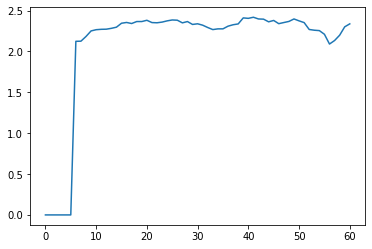

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.006770644842082307,
 'clustered_split_factor': 6,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc8860f5e0>,
 'fit_shape': (3, 2),
 'split': 'browser',
 'split_variance': 0.008292285664370028}


,sessions,rps
clust,,
0.0,2,0.000000
1.0,308468,2.659028


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


browser_clust    0
utc_dt           0
dtype: int64

browser_clust    69
utc_dt           69
dtype: int64

|X| (69, 1)
|--- value: [2.38]

Tree RPS MAE: 0.8670248911591346
|X| (69, 1)
|X| (30, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc885c1520>,
 'fit_shape': (3, 2),
 'split': 'browser',
 'split_variance': 0.008292285664370028}


<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308471,2.659002


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (6, 2),
 'cluster_variance': 0.35884842689688706,
 'clustered_split_factor': 10,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc3f71ad90>,
 'fit_shape': (7, 2),
 'split': 'operating_system',
 'split_variance': 0.35887978347782884}


,sessions,rps
clust,,
0.0,75636,2.536477
1.0,30081,3.020385
2.0,8,0.000000
3.0,66481,3.233667
4.0,128484,2.345681
5.0,7769,2.723652


operating_system    0
utc_dt              0
dtype: int64

operating_system    311
utc_dt              311
dtype: int64

|X| (311, 1)
|--- value: [2.38]

Tree RPS MAE: 0.5204889245610445
|X| (311, 1)
|X| (146, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc13c21d90>,
 'fit_shape': (7, 2),
 'split': 'operating_system',
 'split_variance': 0.35887978347782884}


,sessions,rps
clust,,
0,308460,2.659097


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


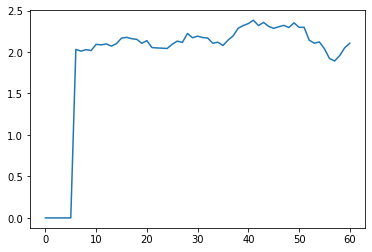

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (6, 2),
 'cluster_variance': 0.35884842689688706,
 'clustered_split_factor': 10,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc3413b460>,
 'fit_shape': (7, 2),
 'split': 'operating_system',
 'split_variance': 0.35887978347782884}


,sessions,rps
clust,,
0.0,75636,2.536477
1.0,30081,3.020385
2.0,8,0.000000
3.0,66481,3.233667
4.0,128484,2.345681
5.0,7769,2.723652


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


operating_system_clust    0
utc_dt                    0
dtype: int64

operating_system_clust    311
utc_dt                    311
dtype: int64

|X| (311, 1)
|--- value: [2.38]

Tree RPS MAE: 0.5204889245610445
|X| (311, 1)
|X| (146, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc3413b100>,
 'fit_shape': (7, 2),
 'split': 'operating_system',
 'split_variance': 0.35887978347782884}


<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308460,2.659097


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38521432936523864,
 'clustered_split_factor': 3,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc3436d490>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.38521432936523864}


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,100386,3.202986
1,196844,2.374736
2,11241,2.778886


device    0
utc_dt    0
dtype: int64

device    183
utc_dt    183
dtype: int64

|X| (183, 1)
|--- value: [2.38]

Tree RPS MAE: 0.49926727561525097
|X| (183, 1)
|X| (84, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc33f46820>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.38521432936523864}


,sessions,rps
clust,,
0,308471,2.659002


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


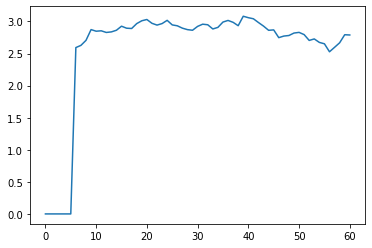

{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38521432936523864,
 'clustered_split_factor': 3,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc3413b2e0>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.38521432936523864}


<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,100386,3.202986
1,196844,2.374736
2,11241,2.778886


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


device_clust    0
utc_dt          0
dtype: int64

device_clust    183
utc_dt          183
dtype: int64

|X| (183, 1)
|--- value: [2.38]

Tree RPS MAE: 0.49926727561525097
|X| (183, 1)
|X| (84, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc885c18b0>,
 'fit_shape': (3, 2),
 'split': 'device',
 'split_variance': 0.38521432936523864}


<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308471,2.659002


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10094025202752242,
 'clustered_split_factor': 2,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc3f71ab20>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.10094025202752242}


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,229568,2.599825
1,78903,2.831178


product    0
utc_dt     0
dtype: int64

product    122
utc_dt     122
dtype: int64

|X| (122, 1)
|--- value: [2.38]

Tree RPS MAE: 0.3453072197301006
|X| (122, 1)
|X| (56, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc30544430>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.10094025202752242}


,sessions,rps
clust,,
0,308471,2.659002


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


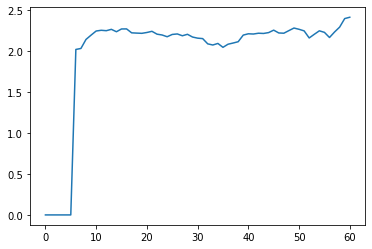

{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (2, 2),
 'cluster_variance': 0.10094025202752242,
 'clustered_split_factor': 2,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc11bd8340>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.10094025202752242}


<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,229568,2.599825
1,78903,2.831178


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


product_clust    0
utc_dt           0
dtype: int64

product_clust    122
utc_dt           122
dtype: int64

<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (122, 1)
|--- value: [2.38]

Tree RPS MAE: 0.3453072197301006
|X| (122, 1)
|X| (56, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc30544e50>,
 'fit_shape': (2, 2),
 'split': 'product',
 'split_variance': 0.10094025202752242}


,sessions,rps
clust,,
0,308471,2.659002


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.47064974478734395,
 'clustered_split_factor': 306,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc3f750850>,
 'fit_shape': (672, 2),
 'split': 'TOD',
 'split_variance': 0.7191670728033276}


,sessions,rps
clust,,
0,649,1.483891
1,9698,3.213571
2,4792,2.178519
3,5143,2.964869
4,2824,1.957631
...,...,...
59,730,2.676743
60,7308,3.164316
61,1606,1.985991


dayofweek    0
hourofday    0
utc_dt       0
dtype: int64

dayofweek       0
hourofday    5425
utc_dt         92
dtype: int64

|X| (6977, 21)
|--- x0_0.0 <= 0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- x1_nan <= 0.50
|   |   |   |--- x0_1.0 <= 0.50
|   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |   |   |--- x0_3.0 <= 0.50
|   |   |   |   |   |   |   |--- value: [2.37]
|   |   |   |   |   |   |--- x0_3.0 >  0.50
|   |   |   |   |   |   |   |--- value: [2.39]
|   |   |   |   |   |--- x0_4.0 >  0.50
|   |   |   |   |   |   |--- value: [2.42]
|   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |--- value: [2.31]
|   |   |   |--- x0_1.0 >  0.50
|   |   |   |   |--- value: [2.06]
|   |   |--- x1_nan >  0.50
|   |   |   |--- x0_4.0 <= 0.50
|   |   |   |   |--- x0_3.0 <= 0.50
|   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |--- x0_5.0 <= 0.50
|   |   |   |   |   |   |   |--- value: [2.57]
|   |   |   |   |   |   |--- x0_5.0 >  0.50
|   |   |   |   |   |   |   |--- value: [2.57]
|   |   |   |   |   |--- x0_2.0 >  0.50
|   |   |   |   |   |   |--- value: [2.5

,sessions,rps
clust,,
7,53332,2.884002
8,41268,2.685619
9,56344,2.631401
10,45251,2.676713
11,68180,2.834442
22,28041,2.206268
25,16055,1.935817


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


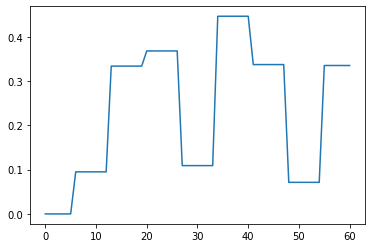

<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.47998403772620546,
 'clustered_split_factor': 276,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc21819460>,
 'fit_shape': (672, 2),
 'split': 'TOD',
 'split_variance': 0.7191670728033276}


,sessions,rps
clust,,
0,4112,2.315590
1,2589,2.018250
2,7490,3.289572
3,977,2.116337
4,5030,2.933385
...,...,...
59,6698,2.767618
60,6415,3.328508
61,439,2.941487


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = c

dayofweek_clust    0
hourofday_clust    0
utc_dt             0
dtype: int64

dayofweek_clust       0
hourofday_clust    2591
utc_dt               92
dtype: int64

<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (6977, 30)
|--- x0_0.0 <= 0.50
|   |--- x1_nan <= 0.50
|   |   |--- x0_6.0 <= 0.50
|   |   |   |--- x1_20.0 <= 0.50
|   |   |   |   |--- x1_61.0 <= 0.50
|   |   |   |   |   |--- x1_30.0 <= 0.50
|   |   |   |   |   |   |--- x1_34.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_6.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_43.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_28.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_42.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |   |--- x1_42.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.84]
|   |   |   |   |   |   |   |   |   |--- x1_28.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.90]
|   |   |   |   |   |   |   |   |--- x1_43.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.94]
|   |   |   |   |   |   |   |--- x1_6.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.38]
|   |   |   | 

,sessions,rps
clust,,
19,26154,2.499621
20,28932,2.711210
21,24165,2.783209
22,21512,2.481289
23,19710,2.605647
24,18692,3.006256
25,13622,2.878692
26,13871,3.016805
27,9904,3.075742


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.49424599899472704,
 'clustered_split_factor': 64,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc440b0f40>,
 'fit_shape': (210, 2),
 'split': 'dma',
 'split_variance': 0.568388172437329}


,sessions,rps
clust,,
0,5787,2.341011
1,14652,3.081809
2,638,3.634672
3,224,1.283664
4,119,2.731345
...,...,...
59,453,2.073964
60,412,2.488366
61,7243,2.890778


dma       0
utc_dt    0
dtype: int64

dma       12425
utc_dt    12425
dtype: int64

|X| (12425, 1)
|--- value: [2.38]

Tree RPS MAE: 2.0672029611411835
|X| (12425, 1)
|X| (5643, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc441039d0>,
 'fit_shape': (210, 2),
 'split': 'dma',
 'split_variance': 0.568388172437329}


,sessions,rps
clust,,
0,308471,2.659002


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


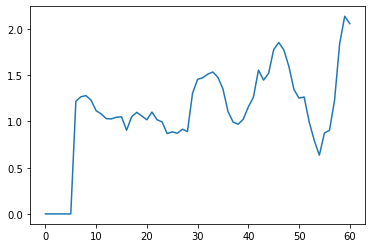

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4740383555084672,
 'clustered_split_factor': 64,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc3042cc40>,
 'fit_shape': (210, 2),
 'split': 'dma',
 'split_variance': 0.568388172437329}


,sessions,rps
clust,,
0,25,0.445010
1,864,2.737174
2,166,2.334410
3,79,1.910380
4,32894,2.824075
...,...,...
59,21974,2.621102
60,31,0.568387
61,5959,3.114025


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


dma_clust    0
utc_dt       0
dtype: int64

dma_clust    1407
utc_dt          0
dtype: int64

<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (12425, 38)
|--- x0_15.0 <= 0.50
|   |--- x0_1.0 <= 0.50
|   |   |--- x0_35.0 <= 0.50
|   |   |   |--- x0_57.0 <= 0.50
|   |   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |   |--- x0_48.0 <= 0.50
|   |   |   |   |   |   |--- x0_62.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_54.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_36.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_49.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_2.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 13
|   |   |   |   |   |   |   |   |   |   |--- x0_2.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.83]
|   |   |   |   |   |   |   |   |   |--- x0_49.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [3.35]
|   |   |   |   |   |   |   |   |--- x0_36.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.80]
|   |   |   |   |   |   |   |--- x0_54.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.95]
|   |   | 

,sessions,rps
clust,,
23,24466,2.481457
25,5602,3.005222
26,15838,2.747026
27,6442,2.678567
28,2183,2.976592
29,15668,2.708546
30,8198,2.741986
31,13832,3.076574
32,42459,2.767035


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (51, 2),
 'cluster_variance': 0.5175120538497789,
 'clustered_split_factor': 51,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc885c17c0>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.5175120538497789}


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


,sessions,rps
clust,,
0,419,1.297547
1,4589,3.398108
2,2931,2.870430
3,5796,2.622743
4,29233,1.902163
5,7169,3.486296
6,2188,1.704230
7,1803,2.621654
8,1015,4.024916


state     0
utc_dt    0
dtype: int64

state     3111
utc_dt    3111
dtype: int64

|X| (3111, 1)
|--- value: [2.38]

Tree RPS MAE: 1.0699379311693162
|X| (3111, 1)
|X| (1428, 1)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc13c21d60>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.5175120538497789}


,sessions,rps
clust,,
0,308471,2.659002


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


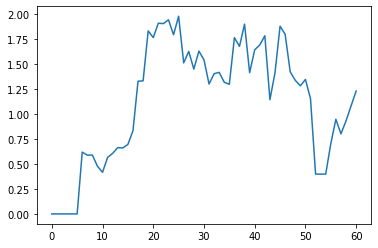

<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (51, 2),
 'cluster_variance': 0.5175120538497789,
 'clustered_split_factor': 51,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc3413b820>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.5175120538497789}


,sessions,rps
clust,,
0,419,1.297547
1,4589,3.398108
2,2931,2.870430
3,5796,2.622743
4,29233,1.902163
5,7169,3.486296
6,2188,1.704230
7,1803,2.621654
8,1015,4.024916


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust    0
utc_dt         0
dtype: int64

state_clust    3111
utc_dt         3111
dtype: int64

|X| (3111, 1)
|--- value: [2.38]

Tree RPS MAE: 1.0699379311693162
|X| (3111, 1)
|X| (1428, 1)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (1, 2),
 'cluster_variance': 0.0,
 'clustered_split_factor': 1,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc341ab610>,
 'fit_shape': (51, 2),
 'split': 'state',
 'split_variance': 0.5175120538497789}


<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


,sessions,rps
clust,,
0,308471,2.659002


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (63, 2),
 'cluster_variance': 0.4809730518170027,
 'clustered_split_factor': 331,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc229dc9d0>,
 'fit_shape': (365, 2),
 'split': 'location',
 'split_variance': 0.6358600286798332}


,sessions,rps
clust,,
0.0,8329,2.616722
1.0,1,0.000000
2.0,37,0.794865
3.0,1234,1.676909
4.0,108,5.681489
...,...,...
59.0,127,3.474582
60.0,60,2.149000
61.0,7,0.642857


state     0
dma       0
utc_dt    0
dtype: int64

state      244
dma       9214
utc_dt       0
dtype: int64

|X| (17892, 114)
|--- x0_NY <= 0.50
|   |--- x0_CA <= 0.50
|   |   |--- x0_FL <= 0.50
|   |   |   |--- x0_MN <= 0.50
|   |   |   |   |--- x1_nan <= 0.50
|   |   |   |   |   |--- x1_511 <= 0.50
|   |   |   |   |   |   |--- x0_TN <= 0.50
|   |   |   |   |   |   |   |--- x0_SC <= 0.50
|   |   |   |   |   |   |   |   |--- x0_IN <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_KY <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x0_OH <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- x0_OH >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [2.66]
|   |   |   |   |   |   |   |   |   |--- x0_KY >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [2.77]
|   |   |   |   |   |   |   |   |--- x0_IN >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.92]
|   |   |   |   |   |   |   |--- x0_SC >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.89]
|   |   |   |   |   |   |--- x0_TN 

,sessions,rps
clust,,
15,133366,2.663465
16,36677,2.973066
17,6542,2.780694
18,15822,3.286759
19,13317,2.632370
20,9275,2.673620
21,4736,2.970020
22,5482,2.995370
23,4725,3.081485


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


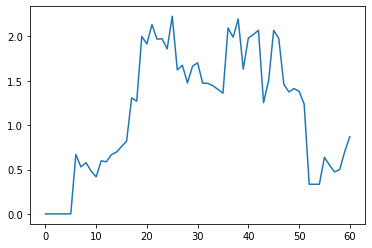

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4437310746890566,
 'clustered_split_factor': 324,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc33e01b80>,
 'fit_shape': (365, 2),
 'split': 'location',
 'split_variance': 0.6358600286798332}


,sessions,rps
clust,,
0.0,40,0.819000
1.0,9775,2.290193
2.0,28,2.804643
3.0,1265,2.027326
4.0,169,2.409439
...,...,...
59.0,81,1.975679
60.0,112,2.732002
61.0,352,2.088556


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

state_clust    0
dma_clust      0
utc_dt         0
dtype: int64

state_clust     244
dma_clust      1280
utc_dt            0
dtype: int64

<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (17892, 90)
|--- x1_32.0 <= 0.50
|   |--- x0_4.0 <= 0.50
|   |   |--- x0_9.0 <= 0.50
|   |   |   |--- x0_23.0 <= 0.50
|   |   |   |   |--- x0_34.0 <= 0.50
|   |   |   |   |   |--- x1_9.0 <= 0.50
|   |   |   |   |   |   |--- x1_29.0 <= 0.50
|   |   |   |   |   |   |   |--- x1_17.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x1_23.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x1_2.0 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- x1_nan <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 20
|   |   |   |   |   |   |   |   |   |   |--- x1_nan >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- value: [3.16]
|   |   |   |   |   |   |   |   |   |--- x1_2.0 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.94]
|   |   |   |   |   |   |   |   |--- x1_23.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [2.57]
|   |   |   |   |   |   |   |--- x1_17.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [2.31]
|   |   |   | 

,sessions,rps
clust,,
30,14695,2.646132
31,1451,2.308039
32,3454,2.655855
33,2722,2.596089
34,864,4.205696
35,1018,3.125108
36,1457,3.206834
37,2264,3.230594
38,1734,2.876266


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (63, 2),
 'cluster_variance': 0.5850585872514428,
 'clustered_split_factor': 244,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc229dcf10>,
 'fit_shape': (1042, 2),
 'split': 'dma_os',
 'split_variance': 0.9015453680689982}


,sessions,rps
clust,,
0.0,18289,2.351742
2.0,564,3.772655
3.0,8,0.606250
4.0,2681,3.676526
5.0,958,1.333667
...,...,...
59.0,12302,2.512735
60.0,11,3.699589
61.0,5245,3.618101


dma                 0
operating_system    0
utc_dt              0
dtype: int64

dma                 745
operating_system      6
utc_dt                0
dtype: int64

|X| (48083, 205)
|--- x1_Windows <= 0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x1_iOS <= 0.50
|   |   |   |--- x1_iPadOS <= 0.50
|   |   |   |   |--- value: [2.21]
|   |   |   |--- x1_iPadOS >  0.50
|   |   |   |   |--- value: [2.38]
|   |   |--- x1_iOS >  0.50
|   |   |   |--- value: [2.00]
|   |--- x1_Mac OS X >  0.50
|   |   |--- value: [2.70]
|--- x1_Windows >  0.50
|   |--- value: [3.01]

Tree RPS MAE: 3.089050829263518
|X| (48083, 205)
|X| (22108, 205)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.3586181862607498,
 'clustered_split_factor': 10,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc2145c4c0>,
 'fit_shape': (1042, 2),
 'split': 'dma_os',
 'split_variance': 0.9015453680689982}


,sessions,rps
clust,,
4,75645,2.536175
5,7769,2.723652
6,128484,2.345681
7,30081,3.020385
8,66481,3.233667


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


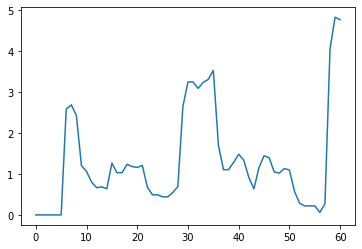

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.4829032061996162,
 'clustered_split_factor': 271,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc11bd8ac0>,
 'fit_shape': (1042, 2),
 'split': 'dma_os',
 'split_variance': 0.9015453680689982}


,sessions,rps
clust,,
0.0,20671,2.728353
1.0,158,2.641329
2.0,440,2.212198
3.0,8973,2.259249
4.0,240,1.798488
...,...,...
59.0,9536,2.748995
60.0,27,1.731196
61.0,991,2.323103


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an

dma_clust                 0
operating_system_clust    0
utc_dt                    0
dtype: int64

dma_clust                 508
operating_system_clust      6
utc_dt                      0
dtype: int64

<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (48083, 62)
|--- x1_3.0 <= 0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- x1_4.0 <= 0.50
|   |   |   |--- x0_30.0 <= 0.50
|   |   |   |   |--- x0_48.0 <= 0.50
|   |   |   |   |   |--- x1_5.0 <= 0.50
|   |   |   |   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |   |   |   |--- value: [2.18]
|   |   |   |   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |   |   |   |--- value: [2.17]
|   |   |   |   |   |--- x1_5.0 >  0.50
|   |   |   |   |   |   |--- value: [2.38]
|   |   |   |   |--- x0_48.0 >  0.50
|   |   |   |   |   |--- value: [2.41]
|   |   |   |--- x0_30.0 >  0.50
|   |   |   |   |--- value: [2.76]
|   |   |--- x1_4.0 >  0.50
|   |   |   |--- x0_6.0 <= 0.50
|   |   |   |   |--- value: [1.99]
|   |   |   |--- x0_6.0 >  0.50
|   |   |   |   |--- value: [2.24]
|   |--- x1_1.0 >  0.50
|   |   |--- value: [2.70]
|--- x1_3.0 >  0.50
|   |--- x0_6.0 <= 0.50
|   |   |--- value: [3.00]
|   |--- x0_6.0 >  0.50
|   |   |--- value: [3.31]

Tree RPS MAE: 3.093222435599895
|X| (48083, 62)
|X| (2210

,sessions,rps
clust,,
7,65436,2.529733
8,2744,2.459164
9,7117,2.748493
10,6096,2.571372
11,2021,2.716162
13,124763,2.339008
14,3721,2.569411
15,30081,3.020385
17,64167,3.222053


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6321937693458837,
 'clustered_split_factor': 147,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc34356a00>,
 'fit_shape': (625, 2),
 'split': 'dma_device',
 'split_variance': 0.831467611557144}


,sessions,rps
clust,,
0.0,5233,3.362565
1.0,1,0.000000
2.0,9016,1.776115
3.0,222,4.978832
4.0,20,10.090500
...,...,...
59.0,125,2.150320
60.0,4943,3.391575
61.0,6642,2.272676


dma       0
device    0
utc_dt    0
dtype: int64

dma       1681
device       0
utc_dt       0
dtype: int64

|X| (30750, 191)
|--- x1_DESK <= 0.50
|   |--- x1_PHON <= 0.50
|   |   |--- value: [2.46]
|   |--- x1_PHON >  0.50
|   |   |--- x0_nan <= 0.50
|   |   |   |--- value: [2.04]
|   |   |--- x0_nan >  0.50
|   |   |   |--- value: [1.96]
|--- x1_DESK >  0.50
|   |--- x0_nan <= 0.50
|   |   |--- value: [2.92]
|   |--- x0_nan >  0.50
|   |   |--- value: [3.22]

Tree RPS MAE: 2.8859295424127014
|X| (30750, 191)
|X| (13975, 191)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38521432936523864,
 'clustered_split_factor': 3,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc2182e400>,
 'fit_shape': (625, 2),
 'split': 'dma_device',
 'split_variance': 0.831467611557144}


,sessions,rps
clust,,
2,11241,2.778886
4,196844,2.374736
7,100386,3.202986


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


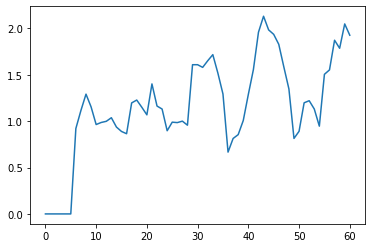

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5607071458194682,
 'clustered_split_factor': 142,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc2233d970>,
 'fit_shape': (625, 2),
 'split': 'dma_device',
 'split_variance': 0.831467611557144}


,sessions,rps
clust,,
0.0,88,2.006818
1.0,19158,2.518269
2.0,542,2.119842
3.0,2245,3.097421
4.0,189,1.622260
...,...,...
59.0,8,5.807500
60.0,163,3.444241
61.0,2531,3.522030


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an

dma_clust       0
device_clust    0
utc_dt          0
dtype: int64

dma_clust       1306
device_clust       0
utc_dt             0
dtype: int64

<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (30750, 50)
|--- x1_0.0 <= 0.50
|   |--- x0_36.0 <= 0.50
|   |   |--- x0_55.0 <= 0.50
|   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |--- x0_44.0 <= 0.50
|   |   |   |   |   |--- value: [2.47]
|   |   |   |   |--- x0_44.0 >  0.50
|   |   |   |   |   |--- value: [2.74]
|   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |--- x0_44.0 <= 0.50
|   |   |   |   |   |--- x0_34.0 <= 0.50
|   |   |   |   |   |   |--- x0_30.0 <= 0.50
|   |   |   |   |   |   |   |--- x0_31.0 <= 0.50
|   |   |   |   |   |   |   |   |--- x0_25.0 <= 0.50
|   |   |   |   |   |   |   |   |   |--- x0_nan <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.96]
|   |   |   |   |   |   |   |   |   |--- x0_nan >  0.50
|   |   |   |   |   |   |   |   |   |   |--- value: [1.96]
|   |   |   |   |   |   |   |   |--- x0_25.0 >  0.50
|   |   |   |   |   |   |   |   |   |--- value: [1.94]
|   |   |   |   |   |   |   |--- x0_31.0 >  0.50
|   |   |   |   |   |   |   |   |--- value: [1.92]
|   |   |   |   |   |   |--- x0

,sessions,rps
clust,,
5,9052,2.737644
6,723,2.835422
13,133783,2.270617
15,2823,2.324463
16,6471,2.702667
17,2819,2.058993
18,11911,2.456508
19,11289,2.818764
20,5234,1.721845


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (59, 2),
 'cluster_variance': 0.5833501532441024,
 'clustered_split_factor': 430,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc341b7430>,
 'fit_shape': (1843, 2),
 'split': 'dma_os_device',
 'split_variance': 1.1166304739855053}


,sessions,rps
clust,,
0.0,20500,2.433880
1.0,2,0.000000
2.0,25,1.350000
3.0,10,0.485000
4.0,744,3.359917
5.0,753,3.543055
6.0,1,0.000000
7.0,15943,3.591550
8.0,9,3.585556


dma                 0
operating_system    0
device              0
utc_dt              0
dtype: int64

dma                 757
operating_system      6
device                0
utc_dt                0
dtype: int64

|X| (56980, 208)
|--- x2_DESK <= 0.50
|   |--- x2_PHON <= 0.50
|   |   |--- x1_Linux <= 0.50
|   |   |   |--- x1_Mac OS X <= 0.50
|   |   |   |   |--- value: [2.39]
|   |   |   |--- x1_Mac OS X >  0.50
|   |   |   |   |--- value: [2.05]
|   |   |--- x1_Linux >  0.50
|   |   |   |--- value: [2.73]
|   |--- x2_PHON >  0.50
|   |   |--- x1_iOS <= 0.50
|   |   |   |--- value: [2.12]
|   |   |--- x1_iOS >  0.50
|   |   |   |--- value: [2.00]
|--- x2_DESK >  0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x1_Linux <= 0.50
|   |   |   |--- value: [3.00]
|   |   |--- x1_Linux >  0.50
|   |   |   |--- value: [3.24]
|   |--- x1_Mac OS X >  0.50
|   |   |--- value: [2.71]

Tree RPS MAE: 3.3223232551659527
|X| (56980, 208)
|X| (26543, 208)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (8, 2),
 'cluster_variance': 0.4008888311379002,
 'clustered_split_factor': 20,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc218091c0>,
 'fit_shape': (1843, 2),
 'split': 'dma_os_device',
 'split_variance': 1.

,sessions,rps
clust,,
4,7732,2.766104
5,612,1.845724
6,2897,3.010132
8,68528,2.430257
9,128305,2.345286
12,66652,3.227295
13,4392,3.884309
14,29342,3.045786


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


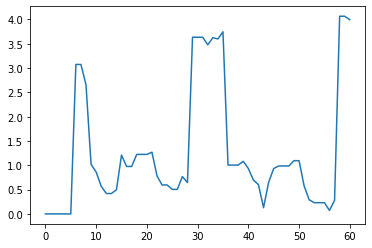

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.46818239349447777,
 'clustered_split_factor': 454,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc210b17c0>,
 'fit_shape': (1843, 2),
 'split': 'dma_os_device',
 'split_variance': 1.1166304739855053}


,sessions,rps
clust,,
0.0,1362,2.563737
1.0,225,2.009279
2.0,561,2.340713
3.0,31027,2.802390
4.0,688,3.400274
...,...,...
59.0,1311,3.654319
60.0,364,3.486255
61.0,200,2.800701


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an

dma_clust                 0
operating_system_clust    0
device_clust              0
utc_dt                    0
dtype: int64

dma_clust                 667
operating_system_clust      6
device_clust                0
utc_dt                      0
dtype: int64

|X| (56980, 63)
|--- x2_0.0 <= 0.50
|   |--- x2_1.0 <= 0.50
|   |   |--- x1_0.0 <= 0.50
|   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |--- value: [2.39]
|   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |--- value: [2.05]
|   |   |--- x1_0.0 >  0.50
|   |   |   |--- value: [2.73]
|   |--- x2_1.0 >  0.50
|   |   |--- x0_27.0 <= 0.50
|   |   |   |--- x0_22.0 <= 0.50
|   |   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |   |--- value: [2.14]
|   |   |   |   |--- x1_4.0 >  0.50
|   |   |   |   |   |--- value: [2.00]
|   |   |   |--- x0_22.0 >  0.50
|   |   |   |   |--- value: [2.63]
|   |   |--- x0_27.0 >  0.50
|   |   |   |--- value: [1.68]
|--- x2_0.0 >  0.50
|   |--- x0_32.0 <= 0.50
|   |   |--- x1_1.0 <= 0.50
|   |   |   |--- x0_27.0 <= 0.50
|   |   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |   |--- value: [3.08]
|   |   |   |   |--- x1_0.0 >  0.50
|   |   |   |   |   |--- value: [3.27]
|   |   |   |--- x0_27.0 >  0.50
|   |   |   |   |--- value: [2.55]
|   |   |--- x1_1.0 >  0.50
|  

<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (12, 2),
 'cluster_variance': 0.4153141146760434,
 'clustered_split_factor': 37,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc33f46910>,
 'fit_shape': (1843, 2),
 'split': 'dma_os_device',
 'split_variance': 1.1166304739855053}


,sessions,rps
clust,,
4,7732,2.766104
5,612,1.845724
6,2897,3.010132
10,64335,2.447448
11,120233,2.346549
12,2796,2.310118
13,9469,2.260467
18,60131,3.277946
19,3931,4.048970


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (63, 2),
 'cluster_variance': 0.6305180209866502,
 'clustered_split_factor': 165,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc3436de80>,
 'fit_shape': (261, 2),
 'split': 'state_os',
 'split_variance': 0.703269087340246}


,sessions,rps
clust,,
0.0,4296,1.928089
1.0,2076,3.390743
2.0,4384,3.860707
3.0,1354,2.030023
4.0,37,1.079897
...,...,...
59.0,5953,2.733035
60.0,1253,1.618255
61.0,3039,3.242048


state               0
operating_system    0
utc_dt              0
dtype: int64

state               0
operating_system    6
utc_dt              0
dtype: int64

|X| (14985, 57)
|--- x1_Windows <= 0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x1_iOS <= 0.50
|   |   |   |--- x1_iPadOS <= 0.50
|   |   |   |   |--- value: [2.21]
|   |   |   |--- x1_iPadOS >  0.50
|   |   |   |   |--- value: [2.38]
|   |   |--- x1_iOS >  0.50
|   |   |   |--- value: [2.00]
|   |--- x1_Mac OS X >  0.50
|   |   |--- value: [2.70]
|--- x1_Windows >  0.50
|   |--- value: [3.01]

Tree RPS MAE: 2.1032946905226817
|X| (14985, 57)
|X| (6862, 57)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.35861818626075,
 'clustered_split_factor': 10,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc33f25700>,
 'fit_shape': (261, 2),
 'split': 'state_os',
 'split_variance': 0.703269087340246}


,sessions,rps
clust,,
4,75645,2.536175
5,7769,2.723652
6,128484,2.345681
7,30081,3.020385
8,66481,3.233667


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


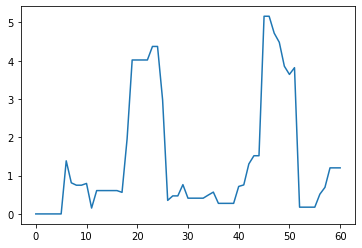

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (63, 2),
 'cluster_variance': 0.6029488731553697,
 'clustered_split_factor': 138,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc33f1bc40>,
 'fit_shape': (261, 2),
 'split': 'state_os',
 'split_variance': 0.703269087340246}


,sessions,rps
clust,,
0.0,16674,1.838125
1.0,78,1.892051
2.0,5255,4.032873
3.0,203,2.333309
5.0,14861,2.632946
...,...,...
59.0,99,3.201248
60.0,1011,2.842826
61.0,17447,3.639857


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)


state_clust               0
operating_system_clust    0
utc_dt                    0
dtype: int64

state_clust               0
operating_system_clust    6
utc_dt                    0
dtype: int64

<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


|X| (14985, 57)
|--- x1_3.0 <= 0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- x1_4.0 <= 0.50
|   |   |   |--- x1_5.0 <= 0.50
|   |   |   |   |--- value: [2.21]
|   |   |   |--- x1_5.0 >  0.50
|   |   |   |   |--- value: [2.38]
|   |   |--- x1_4.0 >  0.50
|   |   |   |--- value: [2.00]
|   |--- x1_1.0 >  0.50
|   |   |--- value: [2.70]
|--- x1_3.0 >  0.50
|   |--- value: [3.01]

Tree RPS MAE: 2.103294690522682
|X| (14985, 57)
|X| (6862, 57)
{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (5, 2),
 'cluster_variance': 0.35861818626075,
 'clustered_split_factor': 10,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc204b65e0>,
 'fit_shape': (261, 2),
 'split': 'state_os',
 'split_variance': 0.703269087340246}


,sessions,rps
clust,,
4,75645,2.536175
5,7769,2.723652
6,128484,2.345681
7,30081,3.020385
8,66481,3.233667


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6624451894882659,
 'clustered_split_factor': 100,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc341abf10>,
 'fit_shape': (153, 2),
 'split': 'state_device',
 'split_variance': 0.701378581466893}


,sessions,rps
clust,,
0,5290,2.840659
1,6553,3.859217
2,3914,1.503067
3,60,2.328835
4,2444,2.969312
...,...,...
59,28271,2.652937
60,5239,2.613617
61,161,1.488487


state     0
device    0
utc_dt    0
dtype: int64

state     0
device    0
utc_dt    0
dtype: int64

|X| (9027, 54)
|--- x1_DESK <= 0.50
|   |--- x1_PHON <= 0.50
|   |   |--- value: [2.46]
|   |--- x1_PHON >  0.50
|   |   |--- value: [2.04]
|--- x1_DESK >  0.50
|   |--- value: [2.92]

Tree RPS MAE: 1.9339376620774968
|X| (9027, 54)
|X| (4132, 54)
{'clust_mtd': 'TreeRPSClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38521432936523864,
 'clustered_split_factor': 3,
 'clusterer': <__main__.TreeRPSClust object at 0x7fcc2233dd60>,
 'fit_shape': (153, 2),
 'split': 'state_device',
 'split_variance': 0.701378581466893}


,sessions,rps
clust,,
2,11241,2.778886
3,196844,2.374736
4,100386,3.202986


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


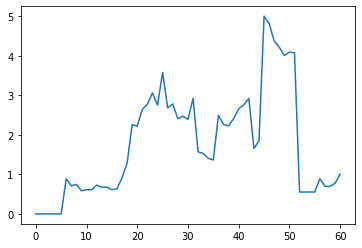

<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.6281829958411534,
 'clustered_split_factor': 76,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc11bc08e0>,
 'fit_shape': (153, 2),
 'split': 'state_device',
 'split_variance': 0.701378581466893}


,sessions,rps
clust,,
0,13796,3.465223
1,1344,1.774349
2,105,4.414605
3,24,1.034008
4,21740,2.517797
...,...,...
59,2667,2.241610
60,196,4.479205
61,242,1.206718


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values


state_clust     0
device_clust    0
utc_dt          0
dtype: int64

state_clust     0
device_clust    0
utc_dt          0
dtype: int64

|X| (9027, 54)
|--- x1_0.0 <= 0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- value: [2.46]
|   |--- x1_1.0 >  0.50
|   |   |--- value: [2.04]
|--- x1_0.0 >  0.50
|   |--- value: [2.92]

Tree RPS MAE: 1.9339376620774968
|X| (9027, 54)
|X| (4132, 54)


<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (3, 2),
 'cluster_variance': 0.38521432936523864,
 'clustered_split_factor': 3,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc33f25f70>,
 'fit_shape': (153, 2),
 'split': 'state_device',
 'split_variance': 0.701378581466893}


,sessions,rps
clust,,
2,11241,2.778886
3,196844,2.374736
4,100386,3.202986


<ipython-input-2-04c7bbf7fd94>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'AggRPSClust',
 'clust_shape': (60, 2),
 'cluster_variance': 0.6441962852248926,
 'clustered_split_factor': 307,
 'clusterer': <__main__.AggRPSClust object at 0x7fcc33e018b0>,
 'fit_shape': (584, 2),
 'split': 'state_os_device',
 'split_variance': 0.8080467357464868}


,sessions,rps
clust,,
0.0,117,1.534074
1.0,3,0.000000
3.0,3363,4.008359
4.0,12,2.996082
5.0,3238,3.407212
6.0,11,1.106364
7.0,3,0.000000
8.0,5482,2.469193
9.0,187,2.398984


state               0
operating_system    0
device              0
utc_dt              0
dtype: int64

state               0
operating_system    6
device              0
utc_dt              0
dtype: int64

|X| (20867, 60)
|--- x2_DESK <= 0.50
|   |--- x0_TX <= 0.50
|   |   |--- x2_PHON <= 0.50
|   |   |   |--- x1_Linux <= 0.50
|   |   |   |   |--- x1_Mac OS X <= 0.50
|   |   |   |   |   |--- value: [2.34]
|   |   |   |   |--- x1_Mac OS X >  0.50
|   |   |   |   |   |--- value: [1.99]
|   |   |   |--- x1_Linux >  0.50
|   |   |   |   |--- value: [2.70]
|   |   |--- x2_PHON >  0.50
|   |   |   |--- x1_iOS <= 0.50
|   |   |   |   |--- value: [2.06]
|   |   |   |--- x1_iOS >  0.50
|   |   |   |   |--- value: [1.95]
|   |--- x0_TX >  0.50
|   |   |--- value: [2.42]
|--- x2_DESK >  0.50
|   |--- x1_Mac OS X <= 0.50
|   |   |--- x1_Linux <= 0.50
|   |   |   |--- x1_Windows <= 0.50
|   |   |   |   |--- value: [2.16]
|   |   |   |--- x1_Windows >  0.50
|   |   |   |   |--- value: [3.01]
|   |   |--- x1_Linux >  0.50
|   |   |   |--- value: [3.24]
|   |--- x1_Mac OS X >  0.50
|   |   |--- value: [2.71]

Tree RPS MAE: 2.6803462875696127
|X| (20867, 60)
|X| (9641, 60)
{'clust_mtd': 'TreeRPSClust',
 

,sessions,rps
clust,,
5,6991,2.709035
6,553,1.536208
7,2636,2.934576
9,59314,2.367686
10,112063,2.307319
11,26517,2.721430
15,284,2.077518
16,66368,3.232215
17,4392,3.884309


/home/amal/anaconda3/envs/hc/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


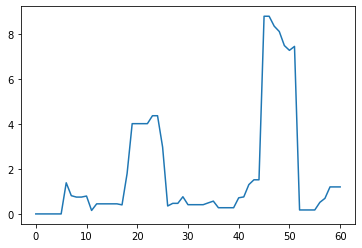

<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)
<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


{'clust_mtd': 'KpiCorrClust',
 'clust_shape': (64, 2),
 'cluster_variance': 0.5890157921631244,
 'clustered_split_factor': 258,
 'clusterer': <__main__.KpiCorrClust object at 0x7fcc20b7de80>,
 'fit_shape': (584, 2),
 'split': 'state_os_device',
 'split_variance': 0.8080467357464868}


,sessions,rps
clust,,
0.0,36117,2.015880
1.0,59,7.575085
2.0,149,5.581581
3.0,8600,3.020695
4.0,557,2.152550
...,...,...
59.0,15798,2.603466
60.0,89,3.797079
61.0,15988,3.818096


<ipython-input-3-cb402270884d>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  clusterer = clust_mtd().fit(rps_df[fitI],None)
<ipython-input-2-04c7bbf7fd94>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[f"{c}_clust"] = clust.values
<ipython-input-2-04c7bbf7fd94>:139: RuntimeWarning: divide by zero encountered in log
  kpi_coprs = np.log(kpi_corps)


state_clust               0
operating_system_clust    0
device_clust              0
utc_dt                    0
dtype: int64

state_clust               0
operating_system_clust    6
device_clust              0
utc_dt                    0
dtype: int64

|X| (20867, 60)
|--- x2_0.0 <= 0.50
|   |--- x0_43.0 <= 0.50
|   |   |--- x2_1.0 <= 0.50
|   |   |   |--- x1_0.0 <= 0.50
|   |   |   |   |--- x1_1.0 <= 0.50
|   |   |   |   |   |--- value: [2.34]
|   |   |   |   |--- x1_1.0 >  0.50
|   |   |   |   |   |--- value: [1.99]
|   |   |   |--- x1_0.0 >  0.50
|   |   |   |   |--- value: [2.70]
|   |   |--- x2_1.0 >  0.50
|   |   |   |--- x1_4.0 <= 0.50
|   |   |   |   |--- value: [2.06]
|   |   |   |--- x1_4.0 >  0.50
|   |   |   |   |--- value: [1.95]
|   |--- x0_43.0 >  0.50
|   |   |--- value: [2.42]
|--- x2_0.0 >  0.50
|   |--- x1_1.0 <= 0.50
|   |   |--- x1_0.0 <= 0.50
|   |   |   |--- x1_3.0 <= 0.50
|   |   |   |   |--- value: [2.16]
|   |   |   |--- x1_3.0 >  0.50
|   |   |   |   |--- value: [3.01]
|   |   |--- x1_0.0 >  0.50
|   |   |   |--- value: [3.24]
|   |--- x1_1.0 >  0.50
|   |   |--- value: [2.71]

Tree RPS MAE: 2.6803462875696127
|X| (20867, 60)
|X| (9641, 60)


<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \
<ipython-input-2-04c7bbf7fd94>:230: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[d] = self.splitcol2clusterer[c] \


{'clust_mtd': 'HybridCorrTreeClust',
 'clust_shape': (10, 2),
 'cluster_variance': 0.41372411151398875,
 'clustered_split_factor': 30,
 'clusterer': <__main__.HybridCorrTreeClust object at 0x7fcc11bc0ee0>,
 'fit_shape': (584, 2),
 'split': 'state_os_device',
 'split_variance': 0.8080467357464868}


,sessions,rps
clust,,
5,6991,2.709035
6,553,1.536208
7,2636,2.934576
9,59314,2.367686
10,112063,2.307319
11,26517,2.721430
15,284,2.077518
16,66368,3.232215
17,4392,3.884309


,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor
0,AggRPSClust,<__main__.AggRPSClust object at 0x7fcc88604610>,browser,"(3, 2)","(2, 2)",0.008292,0.006771,6
1,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fcc885c1880>,browser,"(3, 2)","(1, 2)",0.008292,0.000000,1
2,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fcc8860f5e0>,browser,"(3, 2)","(2, 2)",0.008292,0.006771,6
3,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fcc...,browser,"(3, 2)","(1, 2)",0.008292,0.000000,1
4,AggRPSClust,<__main__.AggRPSClust object at 0x7fcc3f71ad90>,operating_system,"(7, 2)","(6, 2)",0.358880,0.358848,10
5,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fcc13c21d90>,operating_system,"(7, 2)","(1, 2)",0.358880,0.000000,1
6,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fcc3413b460>,operating_system,"(7, 2)","(6, 2)",0.358880,0.358848,10
7,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fcc...,operating_system,"(7, 2)","(1, 2)",0.358880,0.000000,1
8,AggRPSClust,<__main__.AggRPSClust object at 0x7fcc3436d490>,device,"(3, 2)","(3, 2)",0.385214,0.385214,3
9,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fcc33f46820>,device,"(3, 2)","(1, 2)",0.385214,0.000000,1


In [3]:
perfD = []
for split,rps_df in split2aggrps.items():
    
    rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
    rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
    rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
    rps_df["rps"] = rps_df["rps_avg"]
    fitI = rps_df.reset_index()['utc_dt'] < eval_date
    fitI.index = rps_df.index

    for clust_mtd in [AggRPSClust,TreeRPSClust,KpiCorrClust,HybridCorrTreeClust]:
        clusterer = clust_mtd().fit(rps_df[fitI],None)
        rps_df["clust"] = -1
        rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
        rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])

        agg_rps_df = rps_df \
            [~fitI] \
            .groupby(rps_df.index.names[:-1]) \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })
        clust_rps_df = rps_df \
            [~fitI] \
            .groupby("clust") \
            .agg({
                "sessions": sum,
                "rps": get_wavg_by(rps_df[~fitI],"sessions")
            })

        assert clust_rps_df["rps"].max() <= agg_rps_df["rps"].max()
        rps_wavg = wavg(agg_rps_df[["rps"]], agg_rps_df["sessions"])
        rps_clust_wavg = wavg(clust_rps_df[["rps"]], clust_rps_df["sessions"])
        assert all((rps_wavg - rps_clust_wavg).abs() < 1e-2), (rps_wavg, rps_clust_wavg)


        perfd = {
            "clust_mtd": clusterer.__class__.__name__,
            "clusterer": clusterer,
            "split": split,
            "fit_shape": agg_rps_df.shape,
            "clust_shape": clust_rps_df.shape,
            "split_variance": wstd(agg_rps_df["rps"], agg_rps_df["sessions"]),
            "cluster_variance": wstd(clust_rps_df["rps"], clust_rps_df["sessions"]),
            # wstd(rps_df["rps_avg"],rps_df["sessions"])
            "clustered_split_factor": get_split_factor(rps_df),
        }
        perfD.append(perfd)
        pprint.pprint(perfd)
        ipydisp(clust_rps_df)

perfdf = pd.DataFrame(perfD)
ipydisp(perfdf)

In [4]:
perfdf.tail(50)

,clust_mtd,clusterer,split,fit_shape,clust_shape,split_variance,cluster_variance,clustered_split_factor
6,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fcc3413b460>,operating_system,"(7, 2)","(6, 2)",0.358880,0.358848,10
7,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fcc...,operating_system,"(7, 2)","(1, 2)",0.358880,0.000000,1
8,AggRPSClust,<__main__.AggRPSClust object at 0x7fcc3436d490>,device,"(3, 2)","(3, 2)",0.385214,0.385214,3
9,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fcc33f46820>,device,"(3, 2)","(1, 2)",0.385214,0.000000,1
10,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fcc3413b2e0>,device,"(3, 2)","(3, 2)",0.385214,0.385214,3
11,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fcc...,device,"(3, 2)","(1, 2)",0.385214,0.000000,1
12,AggRPSClust,<__main__.AggRPSClust object at 0x7fcc3f71ab20>,product,"(2, 2)","(2, 2)",0.100940,0.100940,2
13,TreeRPSClust,<__main__.TreeRPSClust object at 0x7fcc30544430>,product,"(2, 2)","(1, 2)",0.100940,0.000000,1
14,KpiCorrClust,<__main__.KpiCorrClust object at 0x7fcc11bd8340>,product,"(2, 2)","(2, 2)",0.100940,0.100940,2
15,HybridCorrTreeClust,<__main__.HybridCorrTreeClust object at 0x7fcc...,product,"(2, 2)","(1, 2)",0.100940,0.000000,1


In [14]:
rps_df = split2aggrps[split]
rps_df.index.unique("device")

Index(['DESK', 'PHON', 'TBLT'], dtype='object', name='device')

In [5]:
split,clusterer = perfdf.loc[50,["split","clusterer"]]
print("split:",split)
rps_df = split2aggrps[split]
rps_df["lps"] = rps_df["num_leads"] / rps_df["sessions"]
rps_df["rpl"] = rps_df["revenue"] / rps_df["num_leads"]
rps_df["score"] = rps_df[["score_null_avg","score_adv_avg","score_supp_avg"]].sum(axis=1)
rps_df["rps"] = rps_df["rps_avg"]
fitI = rps_df.reset_index()['utc_dt'] < eval_date
fitI.index = rps_df.index

rps_df["clust"] = -1
rps_df.loc[fitI,"clust"] = clusterer.transform(rps_df[fitI])
rps_df.loc[~fitI,"clust"] = clusterer.transform(rps_df[~fitI])

split_attr2unique_vals = {index_col: rps_df.index.unique(index_col) 
                          for index_col in rps_df.index.names[:-1]}
_,new_index_order = zip(*sorted((V.__len__(),c) for c,V in split_attr2unique_vals.items()))
rps_df = rps_df.reset_index()
campaign_df = rps_df \
    .groupby([*new_index_order[:-1], "clust"]) \
    .agg({
        "sessions": sum,
        "rps_avg": get_wavg_by(rps_df,"sessions"),
        new_index_order[-1]: lambda seq: tuple(set(seq))
    }) \
    .sort_index()

assert campaign_df["sessions"].sum() == rps_df["sessions"].sum()
camp_rps_wavg = wavg(campaign_df["rps_avg"],campaign_df["sessions"])
fit_rps_wavg = wavg(rps_df["rps_avg"], rps_df["sessions"])
assert abs(camp_rps_wavg - fit_rps_wavg) < 1e-5

split: state_device


<ipython-input-2-04c7bbf7fd94>:175: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["clust"] = 1


In [15]:
new_index_order


('device', 'state')

In [20]:
camps = []
for idx,r in campaign_df.iterrows():
    camp = {
        "sessions_60d": r["sessions"], 
        "rps_avg_60d": r["rps_avg"]
    }
    for field,val in zip(new_index_order[:-1],idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "INCLUDE": r[last_field]
    }
    camps.append(camp)

excl_campaign_df = campaign_df.groupby([*new_index_order[:-1]]) \
    .agg({
        new_index_order[-1]: tuple
    })
def flatten(M):
    return tuple(el for r in M for el in r)
excl_campaign_df[new_index_order[-1]] = excl_campaign_df[new_index_order[-1]] \
    .apply(flatten)
for idx, r in excl_campaign_df.iterrows():
    camp = {}
    idx = tuple(idx) if isinstance(idx,(tuple,list,set)) else [idx]
    for field, val in zip(new_index_order[:-1], idx):
        camp[field] = {"INCLUDE": val}
    last_field = new_index_order[-1]
    camp[last_field] = {
        "EXCLUDE": r[last_field]
    }
    camps.append(camp)

camp_attr_df = pd.DataFrame(camps)
camp_attr_df.to_csv("campaign_dump.csv")
camp_attr_df

,sessions_60d,rps_avg_60d,device,state
0,39786.0,3.402218,{'INCLUDE': 'DESK'},"{'INCLUDE': ('TN', 'OH', 'DE', 'MT', 'NV', 'NH..."
1,827.0,1.468970,{'INCLUDE': 'DESK'},"{'INCLUDE': ('RI',)}"
2,736.0,4.741328,{'INCLUDE': 'DESK'},"{'INCLUDE': ('WY',)}"
3,17594.0,3.043467,{'INCLUDE': 'DESK'},"{'INCLUDE': ('OR', 'MS', 'LA', 'UT', 'KY')}"
4,61615.0,3.408672,{'INCLUDE': 'DESK'},"{'INCLUDE': ('IN', 'KS', 'IL', 'NE', 'PA', 'GA..."
...,...,...,...,...
74,519.0,4.353172,{'INCLUDE': 'TBLT'},"{'INCLUDE': ('KY',)}"
75,299.0,2.804050,{'INCLUDE': 'TBLT'},"{'INCLUDE': ('NH',)}"
76,NaN,NaN,{'INCLUDE': 'DESK'},"{'EXCLUDE': ('TN', 'OH', 'DE', 'MT', 'NV', 'NH..."
77,NaN,NaN,{'INCLUDE': 'PHON'},"{'EXCLUDE': ('SC', 'TN', 'IL', 'OH', 'OR', 'RI..."


In [22]:
camp_attr_df.head(20)

,sessions_60d,rps_avg_60d,device,state
0,39786.0,3.402218,{'INCLUDE': 'DESK'},"{'INCLUDE': ('TN', 'OH', 'DE', 'MT', 'NV', 'NH..."
1,827.0,1.468970,{'INCLUDE': 'DESK'},"{'INCLUDE': ('RI',)}"
2,736.0,4.741328,{'INCLUDE': 'DESK'},"{'INCLUDE': ('WY',)}"
3,17594.0,3.043467,{'INCLUDE': 'DESK'},"{'INCLUDE': ('OR', 'MS', 'LA', 'UT', 'KY')}"
4,61615.0,3.408672,{'INCLUDE': 'DESK'},"{'INCLUDE': ('IN', 'KS', 'IL', 'NE', 'PA', 'GA..."
5,1978.0,3.367959,{'INCLUDE': 'DESK'},"{'INCLUDE': ('SD', 'WV')}"
6,8984.0,4.045210,{'INCLUDE': 'DESK'},"{'INCLUDE': ('MD',)}"
7,8618.0,1.489663,{'INCLUDE': 'DESK'},"{'INCLUDE': ('CT', 'MA')}"
8,26005.0,2.299411,{'INCLUDE': 'DESK'},"{'INCLUDE': ('NM', 'DC', 'FL')}"
9,19133.0,2.024362,{'INCLUDE': 'DESK'},"{'INCLUDE': ('NY', 'ID', 'WA', 'ND')}"


In [16]:
excl_campaign_df

,state
device,
DESK,"(TN, OH, DE, MT, NV, NH, AZ, WI, AR, RI, WY, O..."
PHON,"(SC, TN, IL, OH, OR, RI, UT, PA, VT, CT, MA, H..."
TBLT,"(CA, MO, MS, RI, ME, VT, CO, OH, DC, NY, MA, A..."


In [147]:
import json

TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

from pytaboola.services import AccountService
from pytaboola.services import CampaignService

import itertools
import tqdm
import pandas as pd
import os
from pkg_resources import resource_filename as rscfn


acct_service = AccountService(client)
accnts = acct_service.list()["results"]
NETWORK_ACCNT_ID = "healthcareinc-network"
TEST_ACCNT_ID = "healthcareinc-sc2"
O65_ACCNT_ID = "taboolaaccount-rangaritahealthcarecom"
id2accnt = {a["account_id"]: a for a in accnts}

def accnt_camps(accnt):
    camp_service = CampaignService(client, accnt["account_id"])
    return camp_service.list()
aid2cid2camp = {}
for aid,a in tqdm.tqdm(id2accnt.items()):
    cid2camp = {c["id"]: c for c in accnt_camps(a)}
    aid2cid2camp[aid] = cid2camp

import json
json.dump(aid2cid2camp, open("camps.json", "w"))
O65_accnt_camps = accnt_camps(id2accnt[O65_ACCNT_ID])
print("|065_accnt_camps|:",len(O65_accnt_camps))

test_accnt_camps = accnt_camps(id2accnt[TEST_ACCNT_ID])
print("|test_accnt_camps|",len(test_accnt_camps))

import itertools
cross = itertools.product
import jmespath
get = jmespath.search

active_camps = get(
  "*.*[] | [?is_active]",
  aid2cid2camp,
)
print("|active campaigns|:",len(active_camps))

100%|██████████| 6/6 [00:10<00:00,  1.77s/it]


|065_accnt_camps|: 100


In [261]:
def taboola_targetting_fields(r):
    def pivot(o):
        (t,v),*_ = o.items()
        return {
            "type": t,
            "value": [*v] if isinstance(v,(list,tuple,set)) else [v]
        }
    targetting_fields = {}
    if "device" in r:
        targetting_fields["platform_targeting"] = pivot(r["device"])
    if "state" in r:
        targetting_fields["sub_country_targeting"] = pivot(r["state"])
    if "dma" in r:
        targetting_fields["dma_country_targeting"] = pivot(r["dma"])
    if "operating_system" in r:
        (t,v),*_ = r["operating_system"].items()
        targetting_fields["os_targeting"] = {
            "type": "INCLUDE",
            "value": [
                {
                    "os_family": v
                },
            ],
        }
    return targetting_fields
ipydisp(camp_attr_df.apply(taboola_targetting_fields,axis=1).head())
taboola_targetting_fields(camp_attr_df.iloc[0,:])

0    {'platform_targeting': {'type': 'INCLUDE', 'va...
1    {'platform_targeting': {'type': 'INCLUDE', 'va...
2    {'platform_targeting': {'type': 'INCLUDE', 'va...
3    {'platform_targeting': {'type': 'INCLUDE', 'va...
4    {'platform_targeting': {'type': 'INCLUDE', 'va...
dtype: object

{'platform_targeting': {'type': 'INCLUDE', 'value': ['DESK']},
 'sub_country_targeting': {'type': 'INCLUDE', 'value': ['NY', 'FL', 'CA']},
 'os_targeting': {'type': 'INCLUDE', 'value': [{'os_family': 'Android'}]}}

In [269]:
src_accnt = id2accnt[O65_ACCNT_ID]
src_camp = active_camps[0]
dest_accnt = id2accnt[TEST_ACCNT_ID]

client = TaboolaClient(**TABOOLA_HC_CREDS)
client.authorization_header,client.token_details

resp = requests.post(
    f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
    json={
        "name": src_camp["id"],
        "start_date": (TODAY + 2*DAY).__str__(),
        **taboola_targetting_fields(camp_attr_df.iloc[0]),
    },
    params= {
        "destination_account": dest_accnt["account_id"],
    },
    headers=client.authorization_header,)
resp.raise_for_status()

new_camp = resp.json()

HTTPError: 400 Client Error: Bad Request for url: https://backstage.taboola.com/backstage/api/1.0/taboolaaccount-rangaritahealthcarecom/campaigns/10798231/duplicate?destination_account=healthcareinc-sc2

In [ ]:
# import requests
# TODAY = NOW.date()
# TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
# for src_camp in active_camps:
#     src_accnt = id2accnt[O65_ACCNT_ID]
#     dest_accnt = id2accnt[TEST_ACCNT_ID]

#     client = TaboolaClient(**TABOOLA_HC_CREDS)
#     client.authorization_header,client.token_details

#     for _,camp_attrs in camp_attr_df.iterrows():
#         resp = requests.post(
#             f"{TABOOLA_BASE}/{src_accnt['account_id']}/campaigns/{src_camp['id']}/duplicate",
#             json={
#                 "name": src_camp["id"],
#                 "start_date": (TODAY + 2*DAY).__str__(),
#                 **taboola_targetting_fields(camp_attrs),
#             },
#             params= {
#                 "destination_account": dest_accnt["account_id"],
#             },
#             headers=client.authorization_header,)
#         resp.raise_for_status()

#         new_camp = resp.json()

In [165]:
import json
TABOOLA_HC_CREDS = json.loads(os.getenv("TABOOLA_HC_CREDS"))
TABOOLA_PIVOT_CREDS = json.loads(os.getenv("TABOOLA_PIVOT_CREDS"))

from pytaboola import TaboolaClient
client = TaboolaClient(**TABOOLA_HC_CREDS)
client.token_details

import requests
import jmespath
TABOOLA_BASE = "https://backstage.taboola.com/backstage/api/1.0"
resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/operating_systems",
    headers=client.authorization_header)
taboola_os = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/campaigns_properties/platforms",
    headers=client.authorization_header)
taboola_platforms = jmespath.search('results[].name', resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/dma",
    headers=client.authorization_header)
taboola_dmas = jmespath.search('results[].name',resp.json(),)

resp = requests.get(
    f"{TABOOLA_BASE}/resources/countries/us/regions",
    headers=client.authorization_header)
taboola_states = jmespath.search('results[].name',resp.json(),)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.feature_selection
import sklearn.metrics
from matplotlib import pyplot as plt
import sklearn.preprocessing

requires_campaign_split = [
    # "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]

for split in requires_campaign_split:
    rps_df = split2aggrps[split] .reset_index()
    Xs = rps_df \
        .apply(lambda r: [r["int_ix"]]*int(r["sessions"]), axis=1)
    X = np.concatenate(Xs.values).reshape(-1,1)
    ys = rps_df \
        .apply(lambda r: [r["rps_avg"]]*int(r["sessions"]),axis=1)
    y = np.concatenate(ys.values)
    # print(y.min(),np.quantile(y, 0.5),y.max())
    y = y > y.mean()
    # y = np.concatenate(ys.values).reshape(-1,1)
    # y = sklearn.preprocessing.KBinsDiscretizer(n_bins=2,encode="ordinal") \
    #     .fit_transform(y).reshape(-1)
    mi = sklearn.feature_selection.mutual_info_regression(X,y,discrete_features=True)
    print(split,mi,y.mean(),rps_df.shape)

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats
from matplotlib import pyplot as plt

requires_campaign_split = [
    "browser",
    "operating_system",
    "device",
    # "channel", # not actually sure what this is
    # "domain",
    "product",
    # "landing_page",
    "location",
]
combined_rps_df = pd.concat([df.reset_index() for df in split2aggrps.values()])
splitI = combined_rps_df["split_on"].isin(requires_campaign_split)
density = scipy.stats.gaussian_kde(
    dataset=combined_rps_df.loc[splitI,"rps_avg"],
    weights=combined_rps_df.loc[splitI, "sessions"],
    # bw_method="scott",
    # bw_method="silverman",
    # bw_method=0.1,
)
xs = np.linspace(0,2,100)
plt.plot(xs,density(xs))

In [ ]:
for split in requires_campaign_split:
    splitI = combined_rps_df["split_on"] == split
    density = scipy.stats.gaussian_kde(
        dataset=combined_rps_df.loc[splitI, "rps_avg"],
        weights=combined_rps_df.loc[splitI, "sessions"])
    xs = np.linspace(0, 2, 100)
    plt.plot(xs, density(xs))
    plt.title(split)
    plt.show()